# Mouse gliogenesis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import optax
import scanpy as sc

import stories

In [3]:
import jax

jax.devices()

[cuda(id=0)]

## Load the data

In [4]:
current_path = (
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/stories/docs/vignettes/"
)

In [5]:
# Load the data
adata = ad.read_h5ad(
    current_path + "../../../data/dorsal_midbrain/dorsal_midbrain_processed.h5ad"
)
adata

AnnData object with n_obs × n_vars = 4581 × 10000
    obs: 'CellID', 'Batch', 'annotation', 'S_score', 'G2M_score', 'phase', 'Time point', 'time', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'proliferation', 'apoptosis', 'growth'
    var: 'Gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'FP200000600TR_E3', 'SS200000108BR_A3A4', 'SS200000108BR_B1B2', 'SS200000131BL_C3C4', 'SS200000131BL_C5C6', 'angle_dict', 'annotation_colors', 'hvg', 'neighbors', 'pca'
    obsm: 'X_isomap', 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connec

## Preprocess the data

In [6]:
# Some shorthands
space_key = "spatial"
omics_key = "X_pca_harmony"
time_key = "time"
weight_key = "growth"

In [7]:
# Select a given number of principal components then normalize the embedding.
adata.obsm[omics_key] = adata.obsm[omics_key][:, :20]
adata.obsm[omics_key] /= adata.obsm[omics_key].max()
print("Normalized embedding.")

Normalized embedding.


In [8]:
# Center and scale each batch in space.
adata.obsm[space_key] = adata.obsm[space_key].astype(float)
for b in adata.obs["Batch"].unique():
    idx = adata.obs["Batch"] == b

    mu = np.mean(adata.obsm[space_key][idx, :], axis=0)
    adata.obsm[space_key][idx, :] -= mu

    std = np.std(adata.obsm[space_key][idx, :], axis=0)
    adata.obsm[space_key][idx, :] /= std
print("Centered and scaled space.")

Centered and scaled space.


## Train the model

In [9]:
# Initialize the model.
model = stories.SpaceTime(quadratic_weight=1e-3)

In [10]:
scheduler = optax.cosine_decay_schedule(1e-2, 10_000)
model.fit(
    adata=adata,
    time_key=time_key,
    omics_key=omics_key,
    space_key=space_key,
    weight_key=weight_key,
    optimizer=optax.adamw(scheduler),
    checkpoint_manager=current_path + "ckpt",
)

 32%|███▏      | 3151/10000 [08:13<17:52,  6.38it/s, iteration=3152, train_loss=0.022219006, val_loss=0.030805267]


Met early stopping criteria, breaking...


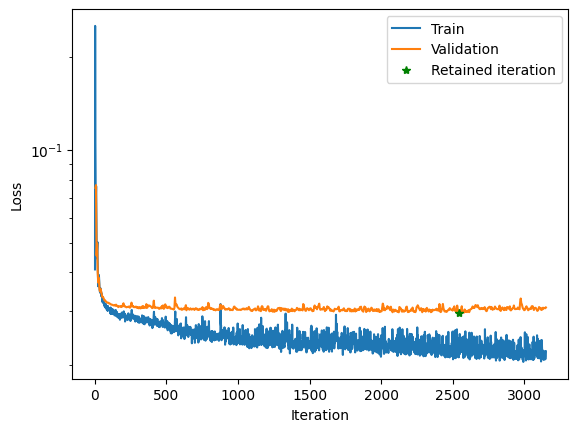

In [11]:
stories.tools.plot_losses(model)

## Display the potential

In [13]:
stories.tools.compute_potential(adata, model, "X_pca_harmony")

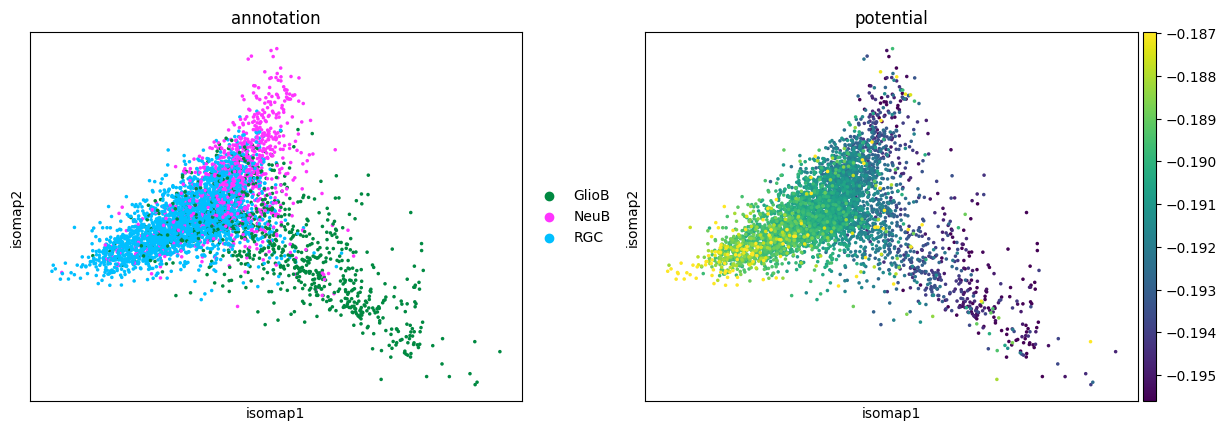

In [14]:
sc.pl.embedding(
    adata, basis="isomap", color=["annotation", "potential"], vmax="p98", vmin="p02"
)

## Display the velocity

In [15]:
stories.tools.compute_velocity(adata, model, "X_pca_harmony")

In [16]:
palette = {"GlioB": "#008941ff", "NeuB": "#ff34ffff", "RGC": "#00bfffff"}

100%|██████████| 4581/4581 [00:01<00:00, 3376.04cell/s]


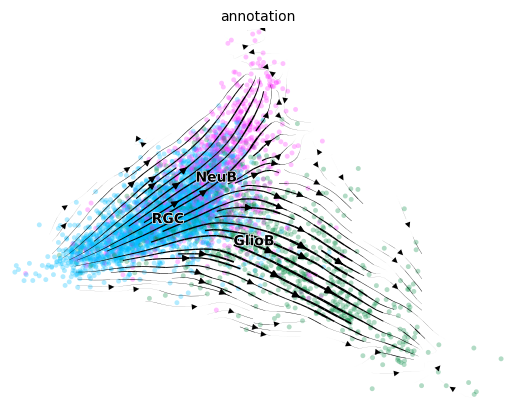

In [17]:
stories.tools.plot_velocity(
    adata, "X_pca_harmony", basis="isomap", color="annotation", palette=palette, s=50
)

## Gene trends

In [18]:
# Subset to trajectory 1
adata = adata[adata.obs["annotation"].isin(["RGC", "GlioB"])].copy()

In [19]:
# pip install magic-impute
import magic

magic_operator = magic.MAGIC()
magic_operator.fit(adata.obsm["X_pca_harmony"])
diff_op_t = np.linalg.matrix_power(magic_operator.diff_op.A, 3)
adata.X = diff_op_t @ np.log1p(adata.layers["counts"].A)

Running MAGIC on 3643 cells and 20 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.29 seconds.
  Calculating affinities...
  Calculated affinities in 0.31 seconds.
Calculated graph and diffusion operator in 0.62 seconds.


In [20]:
stories.tools.regress_genes(adata)

10000it [01:26, 116.17it/s]


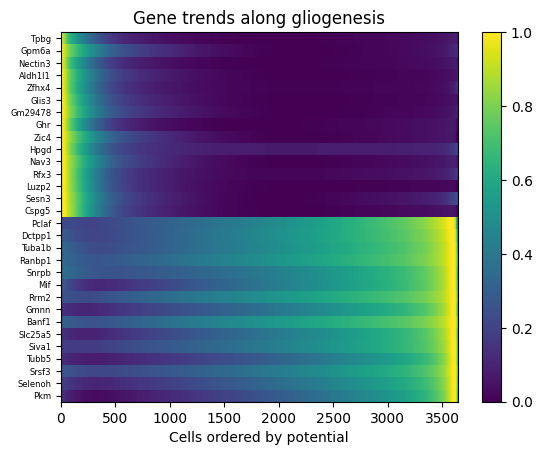

In [21]:
sorted_genes_names = stories.tools.select_driver_genes(adata, n_stages=2, n_genes=15)
fig, ax = stories.tools.plot_gene_trends(
    adata, sorted_genes_names, title="Gene trends along gliogenesis"
)

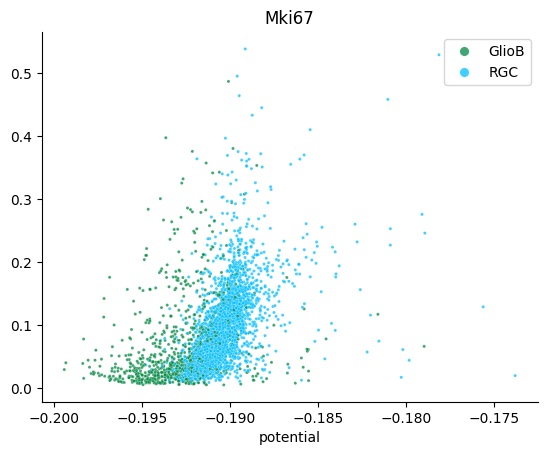

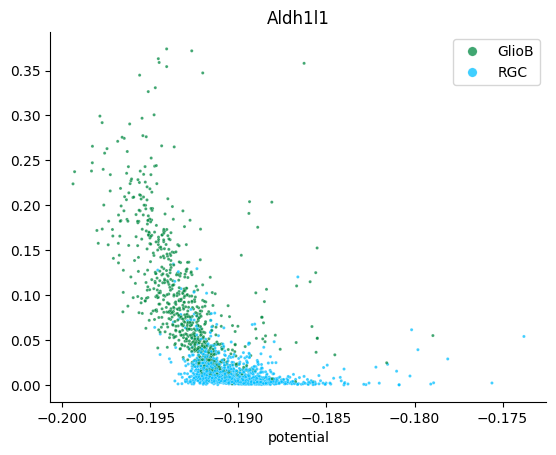

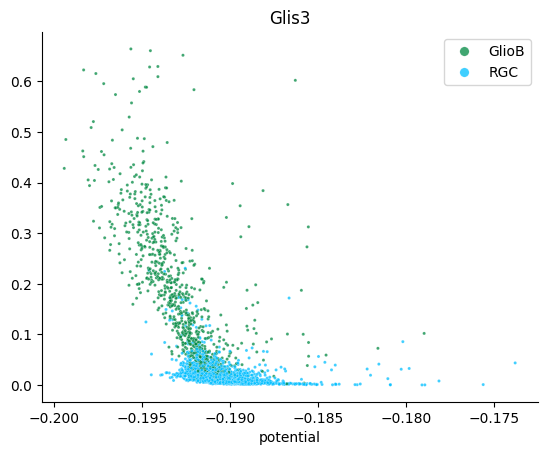

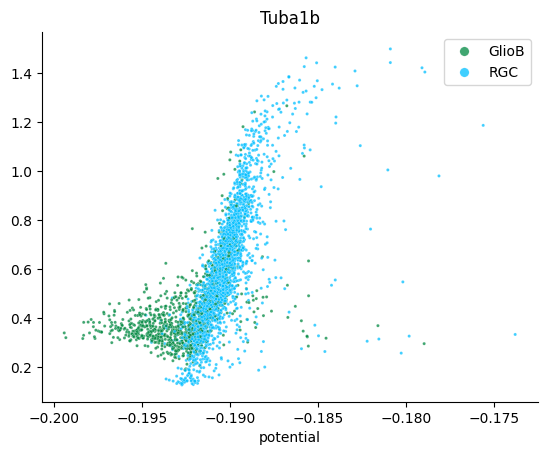

In [22]:
for gene in ["Mki67", "Aldh1l1", "Glis3", "Tuba1b"]:
    stories.tools.plot_single_gene_trend(adata, gene, s=5, palette=palette, alpha=0.75)

## Transcription factors

100%|██████████| 599/599 [00:02<00:00, 234.15it/s]


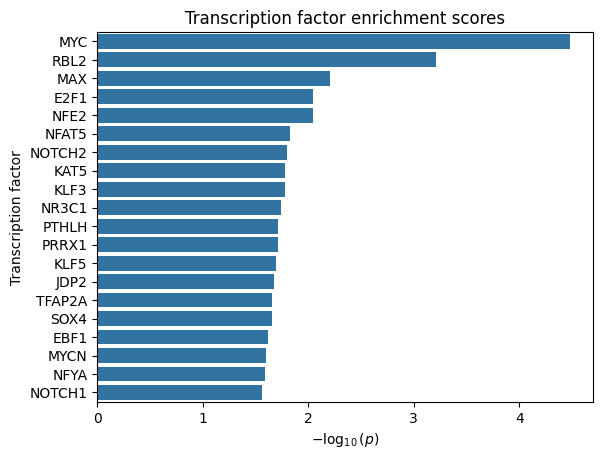

In [23]:
stories.tools.tf_enrich(adata)